In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core')
sys.path.append('/flagellar/input/my-flg-library/')
import flg_support as fls
import importlib
import numpy as np
import flg_diagnostics
import flg_numerics
import matplotlib.pyplot as plt
import glob
import copy
import flg_preprocess
import os
import shutil
import pandas as pd
importlib.reload(fls);

MainProcess
MainProcess


In [2]:
data = fls.load_all_train_data()+fls.load_all_extra_data()

In [3]:
runner = fls.dill_load(fls.result_dir + '/many_abbr_res - Copy/Baseline_0_d7f7501f_.81 _a.pickle')

In [4]:
train_dir = 'd:/flagellar/voxel/train'
test_dir = 'd:/flagellar/voxel/test'
fls.remove_and_make_dir(train_dir)
fls.remove_and_make_dir(test_dir)
#dirs = glob.glob('D:/flagellar/data/train/*')
r = np.random.default_rng(seed=0)
train_labels = dict()
train_labels['filename'] = []
train_labels['voxel_spacing'] = []
test_labels = dict()
test_labels['filename'] = []
test_labels['voxel_spacing'] = []
train_names = [d.name for d in runner.train_data]
test_names = [d.name for d in runner.test_data]
for dat in data:
    if isinstance(dat, fls.DataExtra):
        d = 'd:/flagellar/data/extra/'+dat.name
        scale_fac=10
    else:
        d = 'd:/flagellar/data/train/'+dat.name
        scale_fac = 5
    files = glob.glob(d+'/*')
    files.sort()
    for f in files[::len(files)//scale_fac][1:-1]:
        fname = dat.name+'__'+os.path.basename(f)
        if dat.name in train_names:
            shutil.copyfile(f,train_dir+'/'+fname)
            train_labels['filename'].append(fname)
            train_labels['voxel_spacing'].append(dat.voxel_spacing)
        else:
            assert dat.name in test_names
            shutil.copyfile(f,test_dir+'/'+fname)
            test_labels['filename'].append(fname)
            test_labels['voxel_spacing'].append(dat.voxel_spacing)
pd.DataFrame(train_labels).to_csv(train_dir + '/spacing.csv', index=False)
pd.DataFrame(test_labels).to_csv(test_dir + '/spacing.csv', index=False)



est Epoch 1/200: 100%|██████████████████████████████████████████████████████████████| 155/155 [00:39<00:00,  3.92it/s]

Epoch 1: Train MSE=0.096884, Test MSE=0.032867


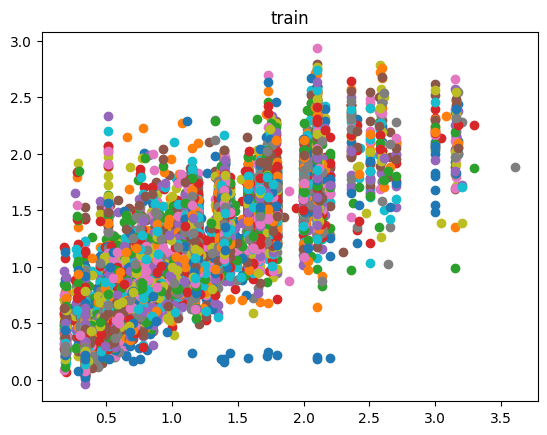

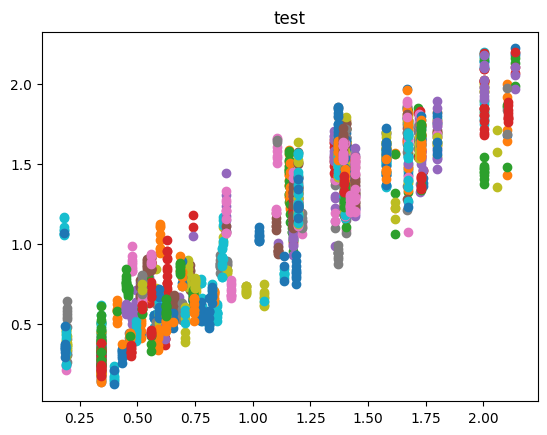



est Epoch 2/200: 100%|██████████████████████████████████████████████████████████████| 155/155 [00:32<00:00,  4.80it/s]

Epoch 2: Train MSE=0.054636, Test MSE=0.042374


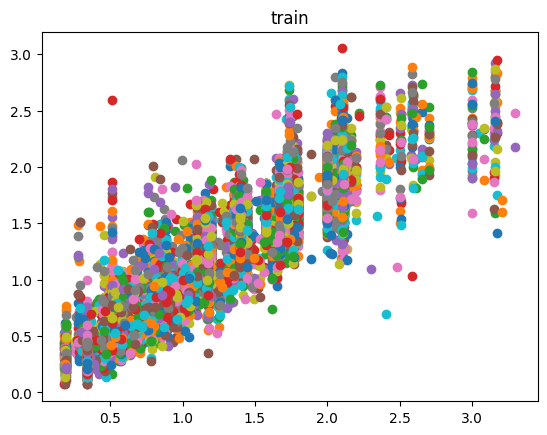

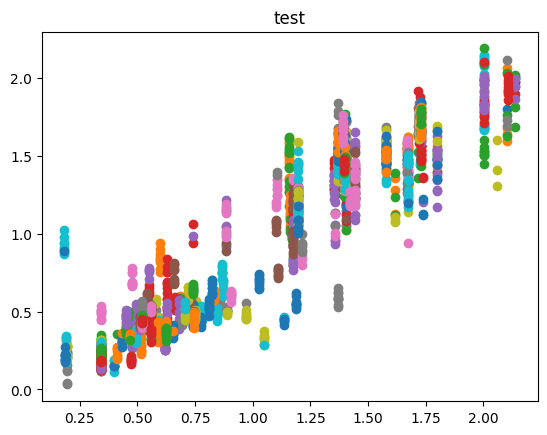



est Epoch 3/200: 100%|██████████████████████████████████████████████████████████████| 155/155 [00:32<00:00,  4.73it/s]

Epoch 3: Train MSE=0.042219, Test MSE=0.024518


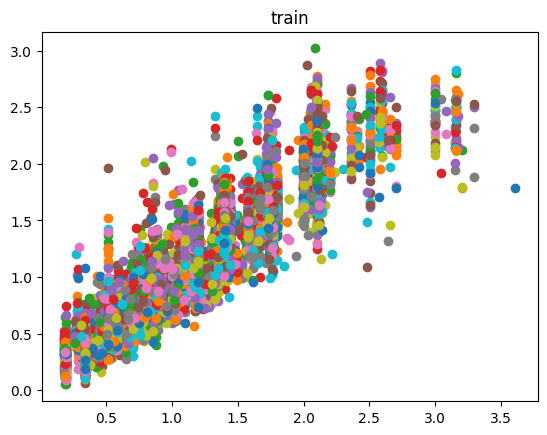

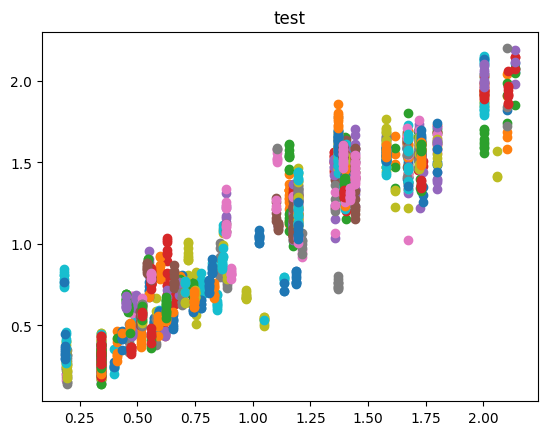



est Epoch 4/200: 100%|██████████████████████████████████████████████████████████████| 155/155 [00:41<00:00,  3.73it/s]

Epoch 4: Train MSE=0.035099, Test MSE=0.034850


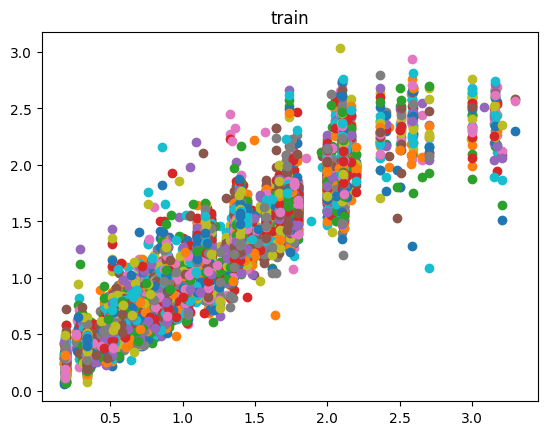

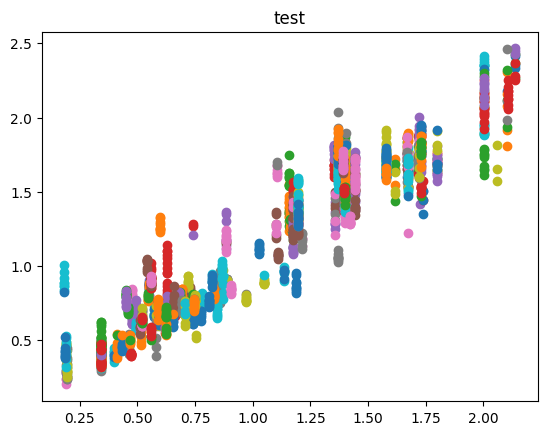



est Epoch 5/200: 100%|██████████████████████████████████████████████████████████████| 155/155 [00:32<00:00,  4.82it/s]

Epoch 5: Train MSE=0.034823, Test MSE=0.022342


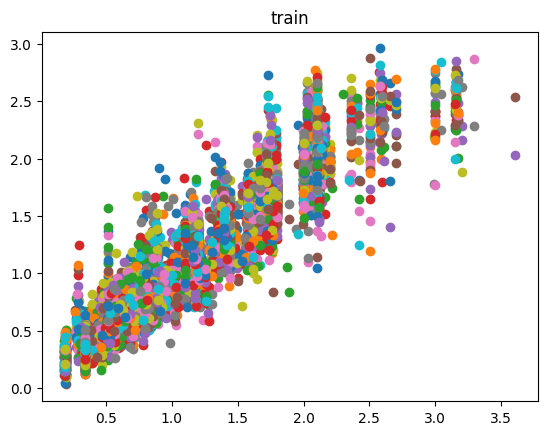

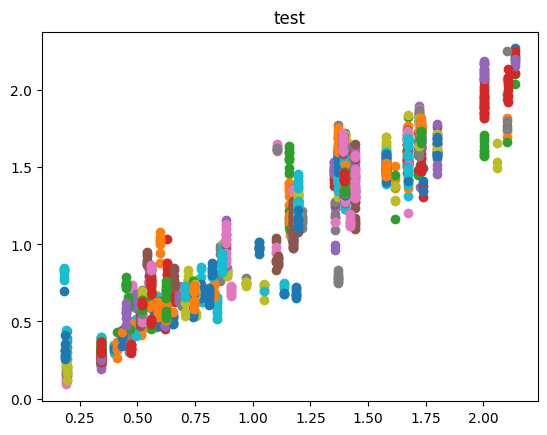



est Epoch 6/200: 100%|██████████████████████████████████████████████████████████████| 155/155 [00:32<00:00,  4.71it/s]

Epoch 6: Train MSE=0.027919, Test MSE=0.041373


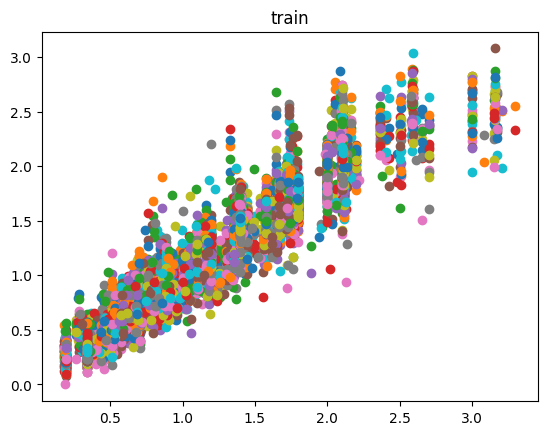

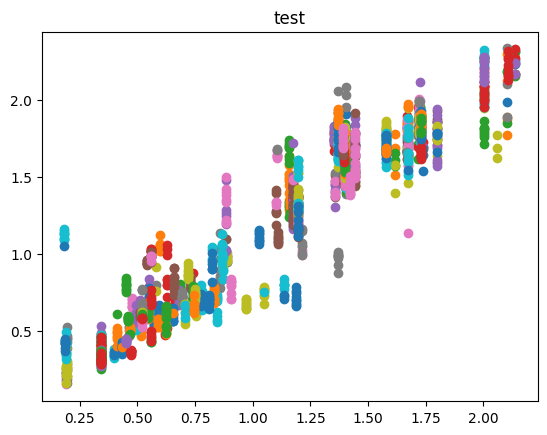



est Epoch 7/200: 100%|██████████████████████████████████████████████████████████████| 155/155 [00:32<00:00,  4.76it/s]

Epoch 7: Train MSE=0.029675, Test MSE=0.029284


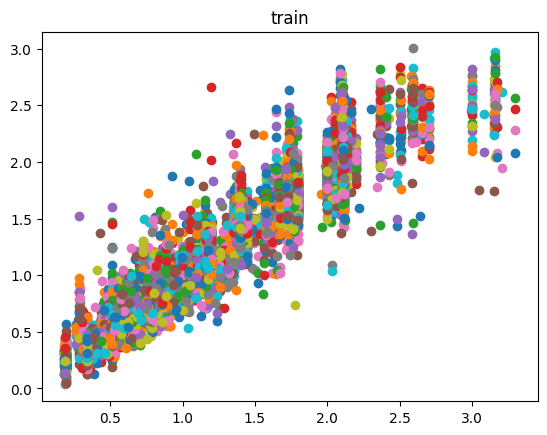

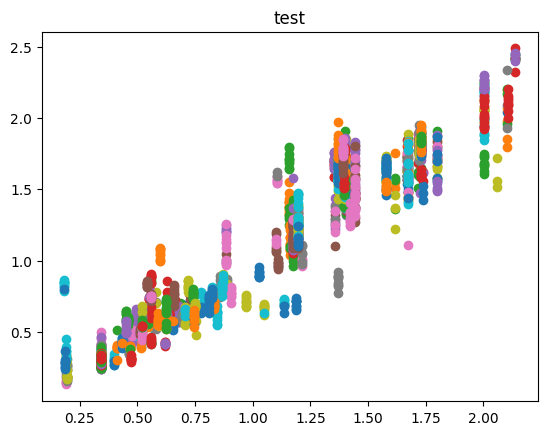



est Epoch 8/200: 100%|██████████████████████████████████████████████████████████████| 155/155 [00:30<00:00,  5.08it/s]

Epoch 8: Train MSE=0.025752, Test MSE=0.023998


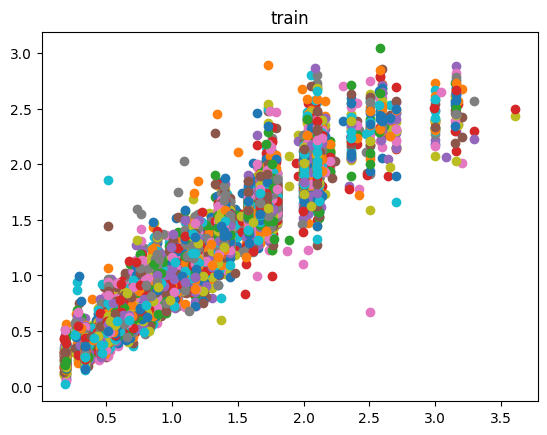

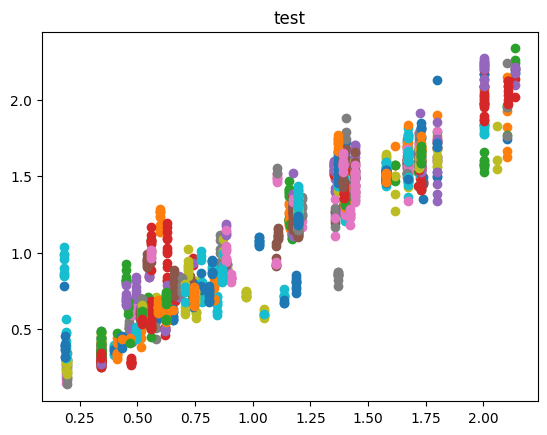



est Epoch 9/200: 100%|██████████████████████████████████████████████████████████████| 155/155 [00:29<00:00,  5.27it/s]

Epoch 9: Train MSE=0.025130, Test MSE=0.020188


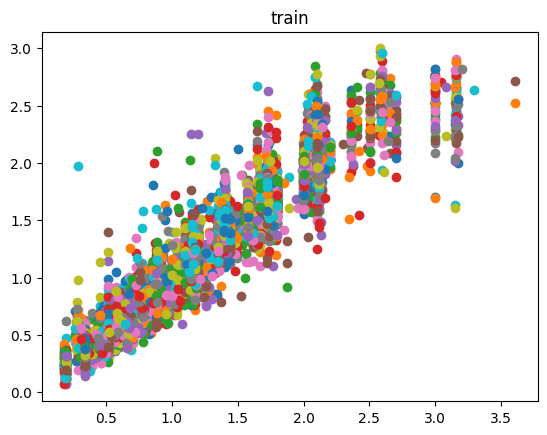

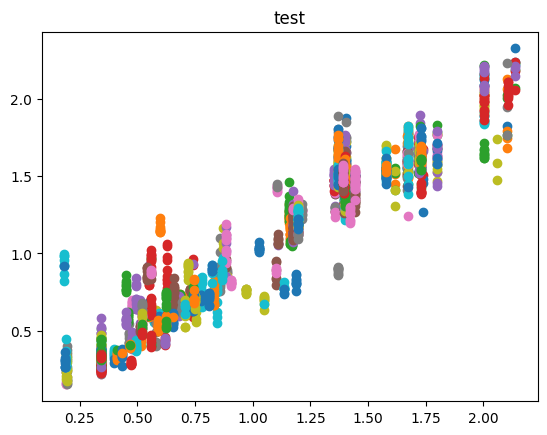



est Epoch 10/200: 100%|█████████████████████████████████████████████████████████████| 155/155 [00:32<00:00,  4.78it/s]

Epoch 10: Train MSE=0.026074, Test MSE=0.025548


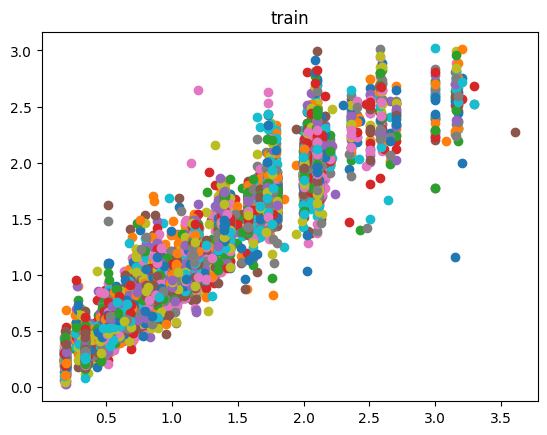

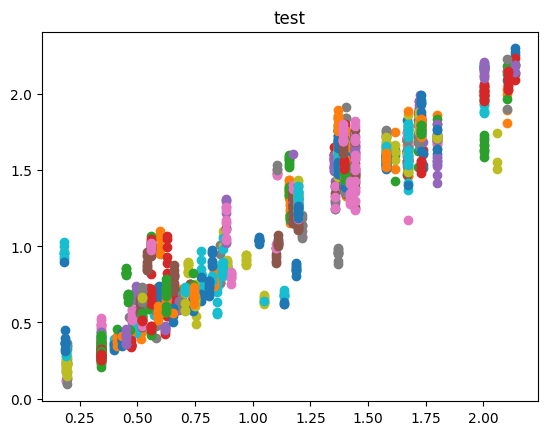



est Epoch 11/200: 100%|█████████████████████████████████████████████████████████████| 155/155 [00:32<00:00,  4.76it/s]

Epoch 11: Train MSE=0.019719, Test MSE=0.020155


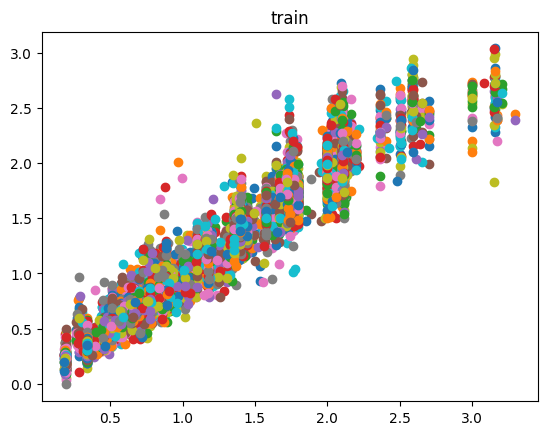

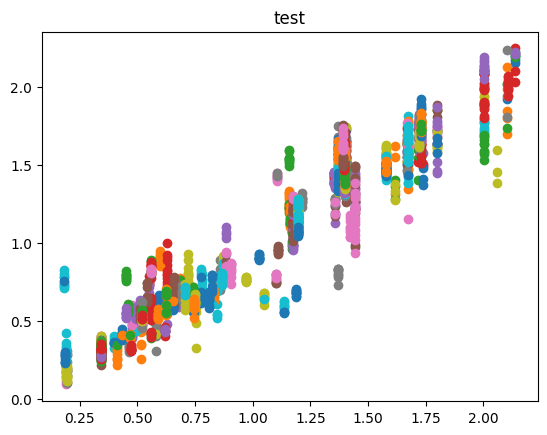



est Epoch 12/200: 100%|█████████████████████████████████████████████████████████████| 155/155 [00:31<00:00,  4.85it/s]

Epoch 12: Train MSE=0.022225, Test MSE=0.027269


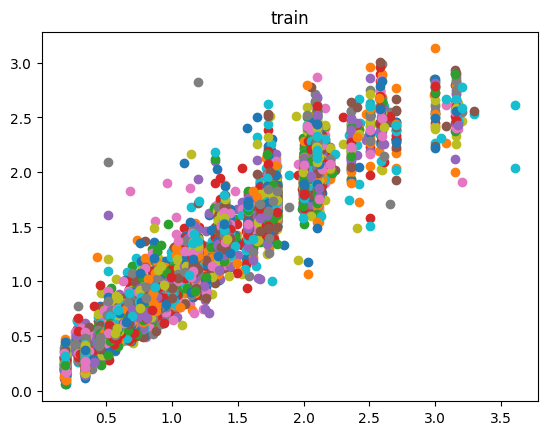

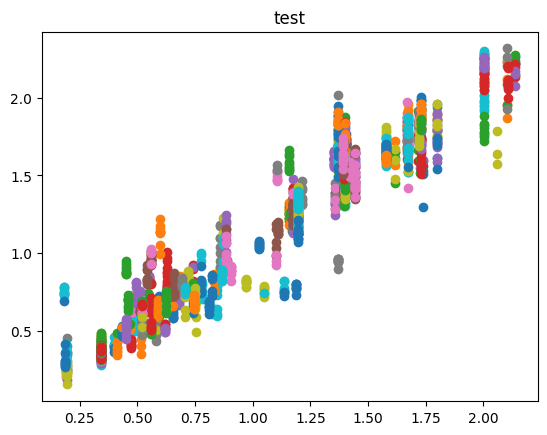

Train Epoch 13/200:  29%|█████████████████▌                                          | 202/691 [00:51<02:07,  3.83it/s]

In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt

# ——— Paths ———
TRAIN_DIR  = r'd:/flagellar/voxel/train'
TRAIN_CSV  = r'd:/flagellar/voxel/train/spacing.csv'
TEST_DIR   = r'd:/flagellar/voxel/test'
TEST_CSV   = r'd:/flagellar/voxel/test/spacing.csv'
OUTPUT_CSV = r'd:/flagellar/voxel/test_predictions.csv'

# ——— Hyperparams ———
BATCH_SIZE = 16
LR         = 1e-4
EPOCHS     = 200
IMG_SIZE   = 224*2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torchvision.transforms import functional as TF

r = np.random.default_rng(seed=0)
scale = 0
class VoxelDataset(Dataset):
    def __init__(self, img_dir, csv_file=None, transform=None, IMG_SIZE=IMG_SIZE, train=True):
        self.img_dir   = img_dir
        self.transform = transform
        self.IMG_SIZE  = IMG_SIZE
        if csv_file:
            df = pd.read_csv(csv_file)
            self.samples = [(row['filename'], float(row['voxel_spacing'])) 
                            for _, row in df.iterrows()]
        else:
            self.samples = [(f, None) for f in sorted(os.listdir(img_dir))
                            if f.lower().endswith('.jpg')]

        self.train = train

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname, orig_spacing = self.samples[idx]
        path = os.path.join(self.img_dir, fname)
        img  = Image.open(path).convert('L')
        orig_w, orig_h = img.size

        # 1) Pad to square on the shorter side
        max_dim = max(orig_w, orig_h)
        pad_w   = max_dim - orig_w
        pad_h   = max_dim - orig_h
        # (left, top, right, bottom)
        padding = (pad_w//2, pad_h//2,
                   pad_w - pad_w//2, pad_h - pad_h//2)
        img = TF.pad(img, padding, fill=0)

        assert max_dim == img.size[0]
        assert max_dim == img.size[0]
        if r.uniform()>0.9 and self.train:
            # pad extra
            img = TF.pad(img, (0,0,max_dim//2,max_dim//2), fill=0)
            max_dim = max_dim + max_dim//2
        assert max_dim == img.size[0]
        assert img.size[0] == img.size[1]


        # 2) Compute the scale factor: new_pixels = old_pixels * (IMG_SIZE/max_dim)
        #    so each new_pixel represents orig_spacing * (max_dim/IMG_SIZE)
        global scale
        if orig_spacing is not None:
            scale       = max_dim / self.IMG_SIZE / 20
            new_spacing = orig_spacing * scale
            #new_spacing = 1
        else:
            new_spacing = None

        # 3) Resize the padded square down to IMG_SIZE×IMG_SIZE
        img = TF.resize(img, [self.IMG_SIZE, self.IMG_SIZE])
        # 4) Run your usual ToTensor+Normalize
        if self.transform:
            img = self.transform(img)

        if r.uniform()>0.5 and self.train:
            img = torch.flip(img,dims=[1])

        if r.uniform()>0.5 and self.train:
            img = torch.flip(img,dims=[2])

        if r.uniform()>0.5 and self.train:
            img = torch.rot90(img, dims=[1,2])


        if new_spacing is None:
            return img, fname, None
        else:
            return img, fname, torch.tensor([new_spacing], dtype=torch.float32)

import torch.nn as nn
from torchvision import models

def replace_bn_with_in(module):
    """
    Recursively walk the module tree and replace all
    nn.BatchNorm2d layers with nn.InstanceNorm2d (affine).
    """
    for name, child in module.named_children():
        # If it's a BatchNorm2d, replace it
        if isinstance(child, nn.BatchNorm2d):
            # preserve the number of channels, enable affine learnable scale & bias
            inst_norm = nn.InstanceNorm2d(
                num_features=child.num_features,
                eps=child.eps,
                momentum=child.momentum,
                affine=True,
                track_running_stats=False  # typically off for InstanceNorm
            )
            setattr(module, name, inst_norm)
        else:
            # recurse into child modules
            replace_bn_with_in(child)
            
def main():
    # — Transforms: uniform scaling, then crop to square
    tfm = transforms.Compose([
        #transforms.Resize(IMG_SIZE),         # smaller side → IMG_SIZE, uniform scale
        #transforms.CenterCrop(IMG_SIZE),    # cut to IMG_SIZE×IMG_SIZE
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

    # Datasets & loaders (use num_workers=0 in JupyterLab)
    train_ds    = VoxelDataset(TRAIN_DIR, TRAIN_CSV, tfm, train=True)
    train_loader= DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True,  num_workers=0, pin_memory=True)
    test_ds     = VoxelDataset(TEST_DIR,  TEST_CSV, tfm, train=False)
    test_loader = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0, pin_memory=True)

    # Model: single-channel ResNet18 → one scalar
    from torchvision.models import resnet18, resnet34, ResNet18_Weights, ResNet34_Weights

    # pick the default ImageNet‐pretrained weights
    weights = ResNet34_Weights.DEFAULT  
    model = resnet34(weights=weights)
    replace_bn_with_in(model)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc    = nn.Linear(model.fc.in_features, 1)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    final_results = []

    for epoch in range(1, EPOCHS+1):
        # — Training —
        model.train()
        train_loss = 0.0
        plt.figure()
        for imgs, _, spacings in tqdm(train_loader, desc=f'Train Epoch {epoch}/{EPOCHS}'):
            imgs     = imgs.to(device)
            spacings = spacings.to(device)
            optimizer.zero_grad()
            preds = model(imgs)            
            plt.scatter(spacings.detach().cpu().numpy(),preds.detach().cpu().numpy())
            loss  = criterion(preds, spacings)
            loss.backward()
            optimizer.step()            
            train_loss += loss.item() * imgs.size(0)
        train_mse = train_loss / len(train_ds)
        plt.title('train')

        # — Testing —
        model.eval()
        test_loss = 0.0
        n_test    = 0
        epoch_results = []
        plt.figure()
        with torch.no_grad():
            for imgs, fnames, spacings in tqdm(test_loader, desc=f'Test Epoch {epoch}/{EPOCHS}'):
                imgs     = imgs.to(device)
                spacings = spacings.to(device)
                #print(spacings)
                preds    = model(imgs)
                plt.scatter(spacings.detach().cpu().numpy(),preds.detach().cpu().numpy())
                #print(preds)
                loss     = criterion(preds, spacings)
                #print(1/imgs.size(0)* torch.sum((preds-spacings)**2), loss)
                test_loss += loss.item() * imgs.size(0)                
                n_test    += imgs.size(0)
                # collect for final scatter
                for i, fname in enumerate(fnames):
                    epoch_results.append({
                        'filename': fname,
                        'predicted': preds[i].item(),
                        'true':      spacings[i].item()
                    })
        test_mse = test_loss / n_test
        plt.title('test')

        print(f'Epoch {epoch}: Train MSE={train_mse:.6f}, Test MSE={test_mse:.6f}')
        final_results = epoch_results  # keep last epoch's
        plt.pause(0.001)

        model.to('cpu')
        fls.dill_save(fls.model_dir + 'voxel_spacing_model' + str(epoch) + '.pickle', model)
        model.to(device)

    # — Save CSV & Plot scatter for final epoch —
    pd.DataFrame(final_results).to_csv(OUTPUT_CSV, index=False)
    print(f'Wrote predictions to {OUTPUT_CSV}')

    truths = [r['true']      for r in final_results]
    preds  = [r['predicted'] for r in final_results]
    plt.figure(figsize=(6,6))
    plt.scatter(truths, preds, alpha=0.7, edgecolor='k')
    mn, mx = min(truths+preds), max(truths+preds)
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel('True Voxel Spacing')
    plt.ylabel('Predicted Voxel Spacing')
    plt.title('Predicted vs True Voxel Spacing (Final Epoch)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
import matplotlib.pyplot as plt

# —– After your `pd.DataFrame(results).to_csv(OUTPUT_CSV, index=False)` call —–

# Extract lists of true and predicted spacings
truths = [r['true_spacing'] for r in results]
preds  = [r['predicted_spacing'] for r in results]

# Make the scatter
plt.figure(figsize=(6,6))
plt.scatter(truths, preds, alpha=0.7, edgecolor='k')
# Plot y=x reference line
mn = min(truths + preds)
mx = max(truths + preds)
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.xlabel('True Voxel Spacing')
plt.ylabel('Predicted Voxel Spacing')
plt.title('Predicted vs. True Voxel Spacing')
plt.grid(True)
plt.tight_layout()
plt.show()